# 1. Get data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

# 2. Export from matlab and see some samples

Dataset shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor labels: (3064,)
Unique labels: [0 1 2]


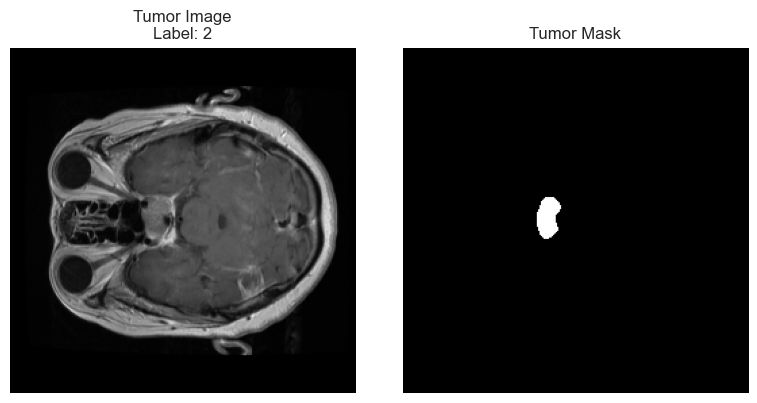

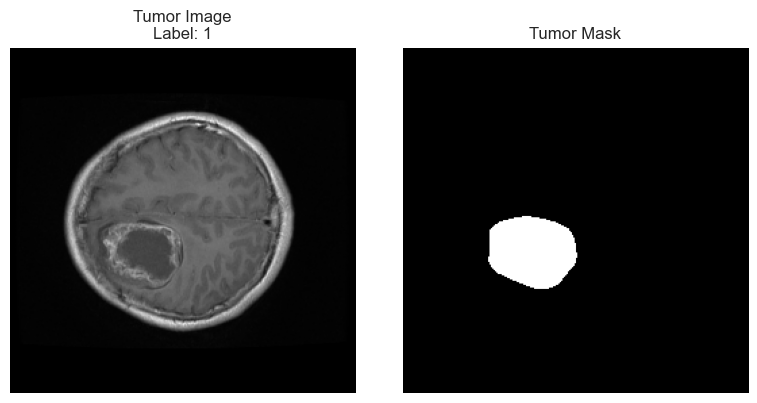

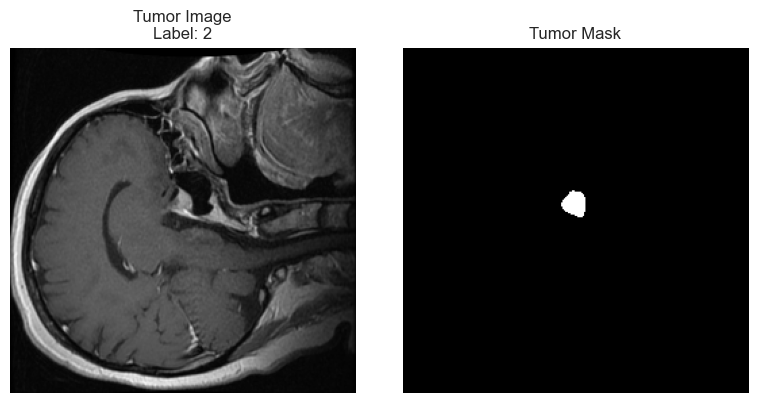

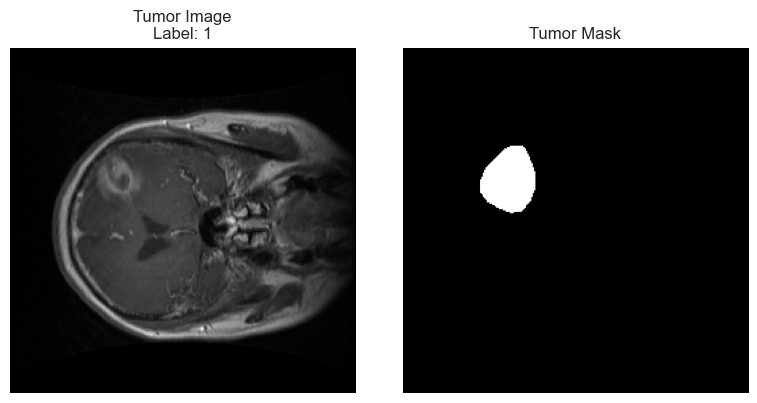

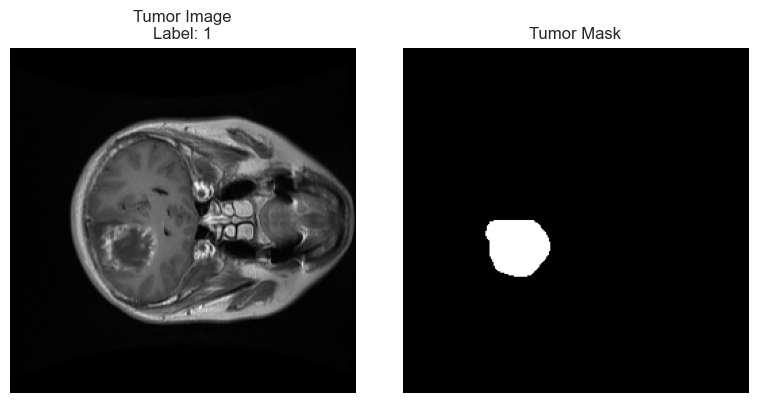

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
# data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data" # pt windows
data_dir = "/Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1/dataset/data" # pt mac
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # image resize and normalize
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # 256x256
        image = image / 255.0  # normalize pixel val to be [0,1]
        X_tumor.append(image)

        # same goes for mask resize and threshold into binary img
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # this is conversion to binary img
        Y_tumor_mask.append(mask)

        # tumor label 1 -> meningioma  2 -> glioma  3 -> pituitary
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to numpy arr
# add extra channel dimension for compatibility with most deep learning models , this is grayscale
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor labels:", tumor_labels.shape)
print("Unique labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocess

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # return if image is already in required measurements
    if current_height == target_height and current_width == target_width:
        return image

    # padding calc
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image


X_tumor_processed = []


for img in X_tumor:
    # convert to grayscale in case it doesnt have enough channels
    if img.ndim == 3 and img.shape[-1] != 1:
        # convert from [0,1] to [0,255] for cv2 manipulation
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # go back to [0,1] and expand dimensions to add channel dimension
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)


Processed X_tumor shape: (3064, 256, 256, 1)


# 4. PyTorch Lightning module

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        labels -> numpy array of shape (N,)
        """
        self.images = images
        self.masks = masks
        self.labels = labels  # added for classification
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # # make images, masks and labels torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]  # 0, 1, 2

        return image, mask, label


    # Lightning dataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, masks, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.labels = labels  # added labels here
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset, now includes labels
        full_dataset = BrainTumorDataset(self.images, self.masks, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator = gen
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


# instantiate data module, batch size already set
data_module = BrainTumorDataModule(X_tumor_processed, Y_tumor_mask, tumor_labels)
data_module.setup()

# initialize loaders
train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
for batch in train_loader:
    images, masks, labels = batch  # technically, it should also include labels
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)    # same here
    print("Batch labels shape:", labels.shape)  # should be (batch_size,)
    break

# this shows how many samples from the test set are for each type of tumor
from collections import Counter
label_counts = Counter()

for images, masks, labels in test_loader:
    label_counts.update(labels.numpy())

for label in sorted(label_counts):
    print(f'Label {label} has {label_counts[label]} images in test set.')

Train size: 2207, Val size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])
Label 0 has 153 images in test set.
Label 1 has 281 images in test set.
Label 2 has 178 images in test set.


# 5. Model unified

In [4]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

# setting seed again to ensure everything is the same every run !!!!!!
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model
class FCNResNet50Lightning(pl.LightningModule):
    def __init__(self, num_classes=1):
        super().__init__()
        self.save_hyperparameters()
        # load pretrained model
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        # replace classifier with new one for binary segmentation
        self.model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        # replicate single channel to 3 channels since model expects RGB input, (won't affect performance)
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        # returns a dictionary, what is needed is the 'out' key
        out = self.model(x)['out']
        # use sigmoid activation to get probabilities
        return torch.sigmoid(out)

    # dice loss function
    def dice_loss(self, preds, targets, epsilon=1e-6):
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * intersection / (union + epsilon)
        return 1 - dice.mean()  # dice loss wil be 1 - current dice coef

    # final combined loss function (BCE + Dice loss with equal contribution)
    def combined_loss(self, preds, masks, bce_weight=0.5, dice_weight=0.5):
        # binary cross entropy
        bce_loss = F.binary_cross_entropy(preds, masks)
        # dice
        dice_loss = self.dice_loss(preds, masks)
        # final loss
        return bce_weight * bce_loss + dice_weight * dice_loss

    # training step with logging
    def training_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # validation step with logging
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    # adam config
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

Seed set to 42


In [5]:
# retrieve and load segmentation only model from part 1
checkpoint_path = 'checkpoints/segmentation_alone.ckpt'
seg_only = FCNResNet50Lightning.load_from_checkpoint(checkpoint_path)

# print model parameters, all should be set to true
for name, p in seg_only.named_parameters():
    print(name, p.requires_grad)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.backbone.conv1.weight True
model.backbone.bn1.weight True
model.backbone.bn1.bias True
model.backbone.layer1.0.conv1.weight True
model.backbone.layer1.0.bn1.weight True
model.backbone.layer1.0.bn1.bias True
model.backbone.layer1.0.conv2.weight True
model.backbone.layer1.0.bn2.weight True
model.backbone.layer1.0.bn2.bias True
model.backbone.layer1.0.conv3.weight True
model.backbone.layer1.0.bn3.weight True
model.backbone.layer1.0.bn3.bias True
model.backbone.layer1.0.downsample.0.weight True
model.backbone.layer1.0.downsample.1.weight True
model.backbone.layer1.0.downsample.1.bias True
model.backbone.layer1.1.conv1.weight True
model.backbone.layer1.1.bn1.weight True
model.backbone.layer1.1.bn1.bias True
model.backbone.layer1.1.conv2.weight True
model.backbone.layer1.1.bn2.weight True
model.backbone.layer1.1.bn2.bias True
model.backbone.layer1.1.conv3.weight True
model.backbone.layer1.1.bn3.weight True
model.backbone.layer1.1.bn3.bias True
model.backbone.layer1.2.conv1.weight True


# Model with classification incorporated

In [6]:
# segmentation + classification model
class SegClfLightning(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # backbone + frozen decoder
        # will retrieve the learned weights from the model in part 1 later
        fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        # freeze segmentation branch
        for name, p in fcn.named_parameters():
            if not name.startswith("backbone"):
                p.requires_grad = False

        # keep encoder
        self.encoder = fcn.backbone

        # classification branch, attached to encoder final feature map
        # backbone ends in a 2048channel output, since FCNResNet is based on ResNet
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # [B, 2048, 1, 1]
            nn.Flatten(),              # therefore it will become [B, 2048]
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    # now, the forward function is adjusted just for classification, after training, we'll modify the structure to also pass segmentation
    def forward(self, x):
        # same explanation as before
        if x.shape[1]==1:
            x = x.repeat(1,3,1,1)

        feats = self.encoder(x)["out"]

        # logits for cls
        logits = self.classifier(feats)
        return logits

    # training step with logging
    def training_step(self, batch, batch_idx):
        images, _masks, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    # ....
    def validation_step(self, batch, batch_idx):
        images, _masks, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)

        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        return loss

    # ....
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


# Model with attention for classification

In [38]:
# Attention module
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [22]:
# Spatial Attention instead of Channel Attention
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

In [39]:
# model
class SegClfLightning(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # backbone + frozen decoder
        # will retrieve the learned weights from the model in part 1 later
        fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        # freeze segmentation branch
        for name, p in fcn.named_parameters():
            if not name.startswith("backbone"):
                p.requires_grad = False

        # keep encoder
        self.encoder = fcn.backbone

        self.attention = SEBlock(2048)

        # classification branch, attached to encoder final feature map
        # backbone ends in a 2048channel output, since FCNResNet is based on ResNet
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # [B, 2048, 1, 1]
            nn.Flatten(),              # therefore it will become [B, 2048]
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    # now, the forward function is adjusted just for classification, after training, we'll modify the structure to also pass segmentation
    def forward(self, x):
        # same explanation as before
        if x.shape[1]==1:
            x = x.repeat(1,3,1,1)

        feats = self.encoder(x)["out"]

        attention_feats = self.attention(feats)

        # logits for cls
        logits = self.classifier(attention_feats)
        return logits

    # training step with logging
    def training_step(self, batch, batch_idx):
        images, _masks, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    # ....
    def validation_step(self, batch, batch_idx):
        images, _masks, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)

        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        return loss

    # ....
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

# 6. Train

In [37]:
# initialize model
model = SegClfLightning()

# retrieve learned weights from segmentation only model
model.encoder.load_state_dict(seg_only.model.backbone.state_dict())

model.seg_decoder = seg_only.model.classifier

# here we freeze the entire segmentation branch
for p in model.seg_decoder.parameters():
    p.requires_grad = False


# this is also part of the freezing process
for p in model.encoder.parameters():
    p.requires_grad = False

# print params to check that everything is good
for name, p in model.named_parameters():
    print(name, p.requires_grad)

# initialize trainer, then train again for 10 epochs, so here we train the classification branch only
# the idea here was to be a staged training, classification here is using the features from segmentation
# so we see if adding classification on top of segmentation will help or not
model.train()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule=data_module)

encoder.conv1.weight False
encoder.bn1.weight False
encoder.bn1.bias False
encoder.layer1.0.conv1.weight False
encoder.layer1.0.bn1.weight False
encoder.layer1.0.bn1.bias False
encoder.layer1.0.conv2.weight False
encoder.layer1.0.bn2.weight False
encoder.layer1.0.bn2.bias False
encoder.layer1.0.conv3.weight False
encoder.layer1.0.bn3.weight False
encoder.layer1.0.bn3.bias False
encoder.layer1.0.downsample.0.weight False
encoder.layer1.0.downsample.1.weight False
encoder.layer1.0.downsample.1.bias False
encoder.layer1.1.conv1.weight False
encoder.layer1.1.bn1.weight False
encoder.layer1.1.bn1.bias False
encoder.layer1.1.conv2.weight False
encoder.layer1.1.bn2.weight False
encoder.layer1.1.bn2.bias False
encoder.layer1.1.conv3.weight False
encoder.layer1.1.bn3.weight False
encoder.layer1.1.bn3.bias False
encoder.layer1.2.conv1.weight False
encoder.layer1.2.bn1.weight False
encoder.layer1.2.bn1.bias False
encoder.layer1.2.conv2.weight False
encoder.layer1.2.bn2.weight False
encoder.layer1

In [40]:
# TRAIN VERSION WITH ATTENTION !!!!
# WITH ATTENTION !!!!!!

# initialize model
model = SegClfLightning()

# retrieve learned weights from segmentation only model
model.encoder.load_state_dict(seg_only.model.backbone.state_dict())

model.seg_decoder = seg_only.model.classifier

# here we freeze the entire segmentation branch
for p in model.seg_decoder.parameters():
    p.requires_grad = False

# this is also part of the freezing process
for p in model.encoder.parameters():
    p.requires_grad = False

# enable last layer
# for name, param in model.encoder.named_parameters():
#     if 'layer4' in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# print params to check that everything is good
for name, p in model.named_parameters():
    print(name, p.requires_grad)

# initialize trainer, then train again for 10 epochs, so here we train the classification branch only
# the idea here was to be a staged training, classification here is using the features from segmentation
# so we see if adding classification on top of segmentation will help or not
model.train()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


encoder.conv1.weight False
encoder.bn1.weight False
encoder.bn1.bias False
encoder.layer1.0.conv1.weight False
encoder.layer1.0.bn1.weight False
encoder.layer1.0.bn1.bias False
encoder.layer1.0.conv2.weight False
encoder.layer1.0.bn2.weight False
encoder.layer1.0.bn2.bias False
encoder.layer1.0.conv3.weight False
encoder.layer1.0.bn3.weight False
encoder.layer1.0.bn3.bias False
encoder.layer1.0.downsample.0.weight False
encoder.layer1.0.downsample.1.weight False
encoder.layer1.0.downsample.1.bias False
encoder.layer1.1.conv1.weight False
encoder.layer1.1.bn1.weight False
encoder.layer1.1.bn1.bias False
encoder.layer1.1.conv2.weight False
encoder.layer1.1.bn2.weight False
encoder.layer1.1.bn2.bias False
encoder.layer1.1.conv3.weight False
encoder.layer1.1.bn3.weight False
encoder.layer1.1.bn3.bias False
encoder.layer1.2.conv1.weight False
encoder.layer1.2.bn1.weight False
encoder.layer1.2.bn1.bias False
encoder.layer1.2.conv2.weight False
encoder.layer1.2.bn2.weight False
encoder.layer1


  | Name        | Type                    | Params | Mode 
----------------------------------------------------------------
0 | encoder     | IntermediateLayerGetter | 23.5 M | train
1 | attention   | SEBlock                 | 524 K  | train
2 | classifier  | Sequential              | 1.1 M  | train
3 | seg_decoder | FCNHead                 | 9.4 M  | train
----------------------------------------------------------------
1.6 M     Trainable params
32.9 M    Non-trainable params
34.5 M    Total params
138.087   Total estimated model params size (MB)
169       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s, v_num=1, train_loss=0.724]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s, v_num=1, train_loss=0.909, val_loss=0.985, val_acc=0.543]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [01:05<00:00,  2.10it/s, v_num=1, train_loss=0.825, val_loss=0.865, val_acc=0.645]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s, v_num=1, train_loss=0.644, val_loss=0.788, val_acc=0.678]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s, v_num=1, train_loss=0.929, val_loss=0.754, val_acc=0.698]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s, v_num=1, train_loss=0.592, val_loss=0.814, val_acc=0.682]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 138/138 [01:05<00:00,  2.11

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [01:12<00:00,  1.91it/s, v_num=1, train_loss=1.050, val_loss=0.682, val_acc=0.735]


# 7. Validation and Test losses

In [41]:
# validation and test losses like before
model.eval()

trainer.validate(model, datamodule=data_module)

print("\n")

model.test_step = model.validation_step

trainer.test(model, datamodule=data_module)

Train size: 2207, Val size: 245, Test size: 612
Validation DataLoader 0:  31%|███▏      | 5/16 [00:01<00:03,  2.83it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [42]:
# validation and test losses like before
# FOR ATTENTION !!!!!!
# FOR ATTENTION !!!!!!
model.eval()

trainer.validate(model, datamodule=data_module)

print("\n")

model.test_step = model.validation_step

trainer.test(model, datamodule=data_module)

Train size: 2207, Val size: 245, Test size: 612
Validation DataLoader 0:  31%|███▏      | 5/16 [00:06<00:14,  0.77it/s]
Validation: |          | 16/? [00:06<00:00,  2.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7346938848495483
        val_loss            0.6817399859428406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.




Train size: 2207, Val size: 245, Test size: 612
Testing DataLoader 0: 100%|██████████| 39/39 [00:16<00:00,  2.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7026143670082092
        val_loss            0.6860965490341187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.6860965490341187, 'val_acc': 0.7026143670082092}]

# 8. Classification results

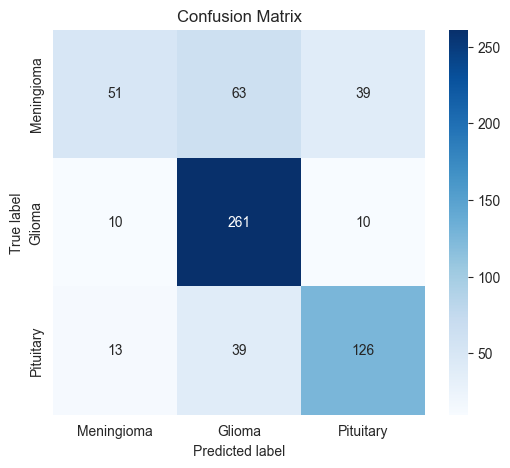

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.6892    0.3333    0.4493       153
      Glioma     0.7190    0.9288    0.8106       281
   Pituitary     0.7200    0.7079    0.7139       178

    accuracy                         0.7157       612
   macro avg     0.7094    0.6567    0.6579       612
weighted avg     0.7118    0.7157    0.6921       612



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# set model to evaluation mode
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(model.device)
        labels = labels.to(model.device)

        logits = model(images)
        preds  = torch.argmax(logits, 1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


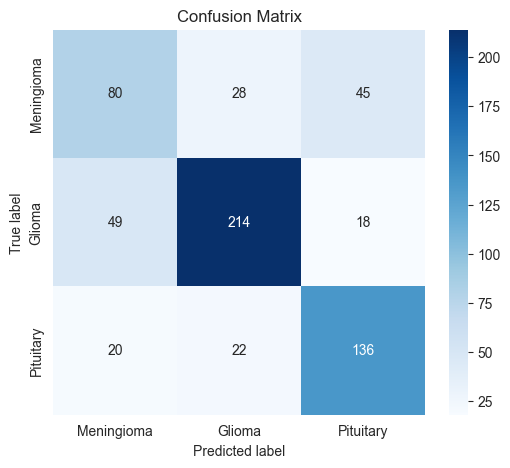

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.5369    0.5229    0.5298       153
      Glioma     0.8106    0.7616    0.7853       281
   Pituitary     0.6834    0.7640    0.7215       178

    accuracy                         0.7026       612
   macro avg     0.6770    0.6828    0.6789       612
weighted avg     0.7052    0.7026    0.7029       612



In [43]:
# FOR ATTENTION !!!!!!
# FOR ATTENTION !!!!!
# with layer 4 unfrozen, 0.96 accuracy

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# set model to evaluation mode
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(model.device)
        labels = labels.to(model.device)

        logits = model(images)
        preds  = torch.argmax(logits, 1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


# Save model

In [28]:
trainer.save_checkpoint("checkpoints/classification_segEnc+Dec_frozen.ckpt")
# trainer.save_checkpoint("checkpoints/classification_segEnc+Dec_frozen_Attention.ckpt")

# 9. Check if model with seg decoder+encoder freezed checkpoint performs the same
  to be sure loading from checkpoint works properly

In [11]:
freezed = SegClfLightning.load_from_checkpoint("checkpoints/classification_segEnc+Dec_frozen.ckpt", strict = False)

freezed.seg_decoder = seg_only.model.classifier

for p in freezed.encoder.parameters():
    p.requires_grad = False

for name, p in freezed.named_parameters():
    print(name, p.requires_grad)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


encoder.conv1.weight False
encoder.bn1.weight False
encoder.bn1.bias False
encoder.layer1.0.conv1.weight False
encoder.layer1.0.bn1.weight False
encoder.layer1.0.bn1.bias False
encoder.layer1.0.conv2.weight False
encoder.layer1.0.bn2.weight False
encoder.layer1.0.bn2.bias False
encoder.layer1.0.conv3.weight False
encoder.layer1.0.bn3.weight False
encoder.layer1.0.bn3.bias False
encoder.layer1.0.downsample.0.weight False
encoder.layer1.0.downsample.1.weight False
encoder.layer1.0.downsample.1.bias False
encoder.layer1.1.conv1.weight False
encoder.layer1.1.bn1.weight False
encoder.layer1.1.bn1.bias False
encoder.layer1.1.conv2.weight False
encoder.layer1.1.bn2.weight False
encoder.layer1.1.bn2.bias False
encoder.layer1.1.conv3.weight False
encoder.layer1.1.bn3.weight False
encoder.layer1.1.bn3.bias False
encoder.layer1.2.conv1.weight False
encoder.layer1.2.bn1.weight False
encoder.layer1.2.bn1.bias False
encoder.layer1.2.conv2.weight False
encoder.layer1.2.bn2.weight False
encoder.layer1

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['seg_decoder.0.weight', 'seg_decoder.1.weight', 'seg_decoder.1.bias', 'seg_decoder.1.running_mean', 'seg_decoder.1.running_var', 'seg_decoder.1.num_batches_tracked', 'seg_decoder.4.weight', 'seg_decoder.4.bias']


In [29]:
# ATTENTION !!!
# ATTENTION !!!

freezed = SegClfLightning.load_from_checkpoint("checkpoints/classification_segEnc+Dec_frozen_Attention.ckpt", strict = False)

# freezed.seg_decoder = seg_only.model.classifier

# for p in freezed.encoder.parameters():
#     p.requires_grad = False

for name, p in freezed.named_parameters():
    print(name, p.requires_grad)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


encoder.conv1.weight True
encoder.bn1.weight True
encoder.bn1.bias True
encoder.layer1.0.conv1.weight True
encoder.layer1.0.bn1.weight True
encoder.layer1.0.bn1.bias True
encoder.layer1.0.conv2.weight True
encoder.layer1.0.bn2.weight True
encoder.layer1.0.bn2.bias True
encoder.layer1.0.conv3.weight True
encoder.layer1.0.bn3.weight True
encoder.layer1.0.bn3.bias True
encoder.layer1.0.downsample.0.weight True
encoder.layer1.0.downsample.1.weight True
encoder.layer1.0.downsample.1.bias True
encoder.layer1.1.conv1.weight True
encoder.layer1.1.bn1.weight True
encoder.layer1.1.bn1.bias True
encoder.layer1.1.conv2.weight True
encoder.layer1.1.bn2.weight True
encoder.layer1.1.bn2.bias True
encoder.layer1.1.conv3.weight True
encoder.layer1.1.bn3.weight True
encoder.layer1.1.bn3.bias True
encoder.layer1.2.conv1.weight True
encoder.layer1.2.bn1.weight True
encoder.layer1.2.bn1.bias True
encoder.layer1.2.conv2.weight True
encoder.layer1.2.bn2.weight True
encoder.layer1.2.bn2.bias True
encoder.laye

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['seg_decoder.0.weight', 'seg_decoder.1.weight', 'seg_decoder.1.bias', 'seg_decoder.1.running_mean', 'seg_decoder.1.running_var', 'seg_decoder.1.num_batches_tracked', 'seg_decoder.4.weight', 'seg_decoder.4.bias']


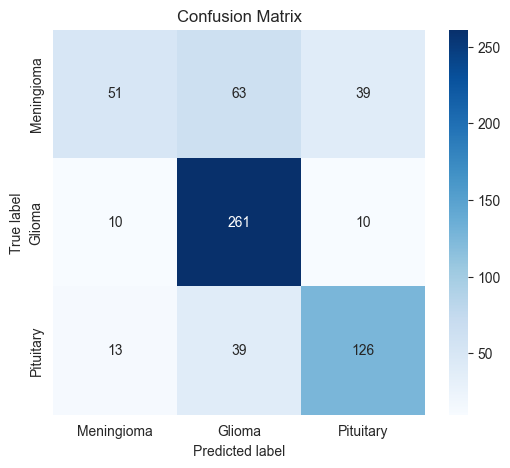

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.6892    0.3333    0.4493       153
      Glioma     0.7190    0.9288    0.8106       281
   Pituitary     0.7200    0.7079    0.7139       178

    accuracy                         0.7157       612
   macro avg     0.7094    0.6567    0.6579       612
weighted avg     0.7118    0.7157    0.6921       612



In [12]:
freezed.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(freezed.device)
        labels = labels.to(freezed.device)

        logits = freezed(images)
        preds  = torch.argmax(logits, 1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))

# 10. Adjust freezed model to return masks as well, then check segmentation performance

In [13]:
# here we adjust forward method to return also logits for segmentation
class SegClfLightning(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        full_fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

        for name, p in full_fcn.named_parameters():
            if not name.startswith("backbone"):
                p.requires_grad = False

        self.encoder = full_fcn.backbone

        self.seg_decoder = full_fcn.classifier

        # solved error for missing keys when loading
        self.seg_decoder[4] = nn.Conv2d(512, 1, kernel_size=1)

        # classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
        self.lr = lr

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1,3,1,1)
        feats = self.encoder(x)["out"]

        # segmentation output are upsampled inside segmentation decoder
        seg_logits = self.seg_decoder(feats)
        seg_out    = torch.sigmoid(seg_logits)

        # classification
        cls_logits = self.classifier(feats)

        return seg_out, cls_logits

    def dice_loss(self, preds, targets, epsilon=1e-6):
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * intersection / (union + epsilon)
        return 1 - dice.mean()

    def combined_loss(self, preds, masks, bce_weight=0.5, dice_weight=0.5):
        bce_loss = F.binary_cross_entropy(preds, masks)
        dice_loss = self.dice_loss(preds, masks)
        return bce_weight * bce_loss + dice_weight * dice_loss

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_out, cls_logits = self(images)

        clf_loss = F.cross_entropy(cls_logits, labels)
        self.log("train_loss", clf_loss)
        return clf_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_out, cls_logits = self(images)

        clf_loss = F.cross_entropy(cls_logits, labels)
        preds     = cls_logits.argmax(dim=1)
        acc       = (preds == labels).float().mean()
        self.log("val_loss", clf_loss)
        self.log("val_acc", acc)
        return clf_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [30]:
# ATTENTION !!!
# ATTENTION !!!
# Adjusted model to return masks also with ATTENTION
# here we adjust forward method to return also logits for segmentation

class SegClfLightning(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        full_fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

        for name, p in full_fcn.named_parameters():
            if not name.startswith("backbone"):
                p.requires_grad = False

        self.encoder = full_fcn.backbone

        self.seg_decoder = full_fcn.classifier

        self.attention = SEBlock(2048)

        # solved error for missing keys when loading
        self.seg_decoder[4] = nn.Conv2d(512, 1, kernel_size=1)

        # classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
        self.lr = lr

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1,3,1,1)
        feats = self.encoder(x)["out"]

        # segmentation output are upsampled inside segmentation decoder
        seg_logits = self.seg_decoder(feats)
        seg_out    = torch.sigmoid(seg_logits)

        # classification
        attention_feats = self.attention(feats)
        cls_logits = self.classifier(attention_feats)

        return seg_out, cls_logits

    def dice_loss(self, preds, targets, epsilon=1e-6):
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * intersection / (union + epsilon)
        return 1 - dice.mean()

    def combined_loss(self, preds, masks, bce_weight=0.5, dice_weight=0.5):
        bce_loss = F.binary_cross_entropy(preds, masks)
        dice_loss = self.dice_loss(preds, masks)
        return bce_weight * bce_loss + dice_weight * dice_loss

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_out, cls_logits = self(images)

        clf_loss = F.cross_entropy(cls_logits, labels)
        self.log("train_loss", clf_loss)
        return clf_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_out, cls_logits = self(images)

        clf_loss = F.cross_entropy(cls_logits, labels)
        preds     = cls_logits.argmax(dim=1)
        acc       = (preds == labels).float().mean()
        self.log("val_loss", clf_loss)
        self.log("val_acc", acc)
        return clf_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [14]:
# freezed_2 represents the version of freezed which also returns masks, not just labels
freezed_2 = SegClfLightning.load_from_checkpoint("checkpoints/classification_segEnc+Dec_frozen.ckpt")

freezed_2.seg_decoder = seg_only.model.classifier

# turn on segmentation params
for p in freezed_2.seg_decoder.parameters():
    p.requires_grad = True

for p in freezed_2.encoder.parameters():
    p.requires_grad = True

for name, p in freezed_2.named_parameters():
    print(name, p.requires_grad)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


encoder.conv1.weight True
encoder.bn1.weight True
encoder.bn1.bias True
encoder.layer1.0.conv1.weight True
encoder.layer1.0.bn1.weight True
encoder.layer1.0.bn1.bias True
encoder.layer1.0.conv2.weight True
encoder.layer1.0.bn2.weight True
encoder.layer1.0.bn2.bias True
encoder.layer1.0.conv3.weight True
encoder.layer1.0.bn3.weight True
encoder.layer1.0.bn3.bias True
encoder.layer1.0.downsample.0.weight True
encoder.layer1.0.downsample.1.weight True
encoder.layer1.0.downsample.1.bias True
encoder.layer1.1.conv1.weight True
encoder.layer1.1.bn1.weight True
encoder.layer1.1.bn1.bias True
encoder.layer1.1.conv2.weight True
encoder.layer1.1.bn2.weight True
encoder.layer1.1.bn2.bias True
encoder.layer1.1.conv3.weight True
encoder.layer1.1.bn3.weight True
encoder.layer1.1.bn3.bias True
encoder.layer1.2.conv1.weight True
encoder.layer1.2.bn1.weight True
encoder.layer1.2.bn1.bias True
encoder.layer1.2.conv2.weight True
encoder.layer1.2.bn2.weight True
encoder.layer1.2.bn2.bias True
encoder.laye

In [31]:
# ATTENTION !!!
# ATTENTION !!!

# freezed_2 represents the version of freezed which also returns masks, not just labels
freezed_2 = SegClfLightning.load_from_checkpoint("checkpoints/classification_segEnc+Dec_frozen_Attention.ckpt")

# turn on segmentation params
for p in freezed_2.seg_decoder.parameters():
    p.requires_grad = True

for p in freezed_2.encoder.parameters():
    p.requires_grad = True

for name, p in freezed_2.named_parameters():
    print(name, p.requires_grad)

encoder.conv1.weight True
encoder.bn1.weight True
encoder.bn1.bias True
encoder.layer1.0.conv1.weight True
encoder.layer1.0.bn1.weight True
encoder.layer1.0.bn1.bias True
encoder.layer1.0.conv2.weight True
encoder.layer1.0.bn2.weight True
encoder.layer1.0.bn2.bias True
encoder.layer1.0.conv3.weight True
encoder.layer1.0.bn3.weight True
encoder.layer1.0.bn3.bias True
encoder.layer1.0.downsample.0.weight True
encoder.layer1.0.downsample.1.weight True
encoder.layer1.0.downsample.1.bias True
encoder.layer1.1.conv1.weight True
encoder.layer1.1.bn1.weight True
encoder.layer1.1.bn1.bias True
encoder.layer1.1.conv2.weight True
encoder.layer1.1.bn2.weight True
encoder.layer1.1.bn2.bias True
encoder.layer1.1.conv3.weight True
encoder.layer1.1.bn3.weight True
encoder.layer1.1.bn3.bias True
encoder.layer1.2.conv1.weight True
encoder.layer1.2.bn1.weight True
encoder.layer1.2.bn1.bias True
encoder.layer1.2.conv2.weight True
encoder.layer1.2.bn2.weight True
encoder.layer1.2.bn2.bias True
encoder.laye

# See if dice coef remained the same

In [32]:
freezed_2.eval()

def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, *_ in test_loader:
        imgs  = imgs.to(freezed_2.device)
        masks = masks.to(freezed_2.device)
        seg_out, _ = freezed_2(imgs)
        seg_out = F.interpolate(                      # upsample back since frozen model with class logits returns 32x32, needed 256x256 for mask
                        seg_out,
                        size=masks.shape[2:],
                        mode="bilinear",
                        align_corners=False
                    )
        dice_scores.append(dice_coef(seg_out, masks, thr=0.65))

print("Seg+Clf model dice at same threshold ", sum(dice_scores)/len(dice_scores)) # 0.7309, baseline is 0.7311

KeyboardInterrupt: 

In [33]:
# ATTENTION !!!!
# ATTENTION !!!!
freezed_2.eval()

def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, *_ in test_loader:
        imgs  = imgs.to(freezed_2.device)
        masks = masks.to(freezed_2.device)
        seg_out, _ = freezed_2(imgs)
        seg_out = F.interpolate(                      # upsample back since frozen model with class logits returns 32x32, needed 256x256 for mask
            seg_out,
            size=masks.shape[2:],
            mode="bilinear",
            align_corners=False
        )
        dice_scores.append(dice_coef(seg_out, masks, thr=0.65))

print("Seg+Clf model dice at same threshold ", sum(dice_scores)/len(dice_scores)) # 0.2419

Seg+Clf model dice at same threshold  0.24193552556710365


# Combined output

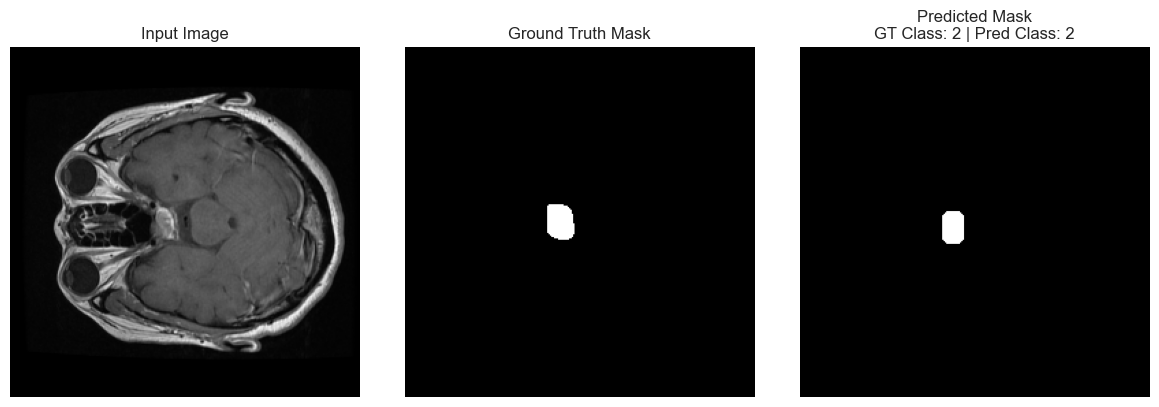

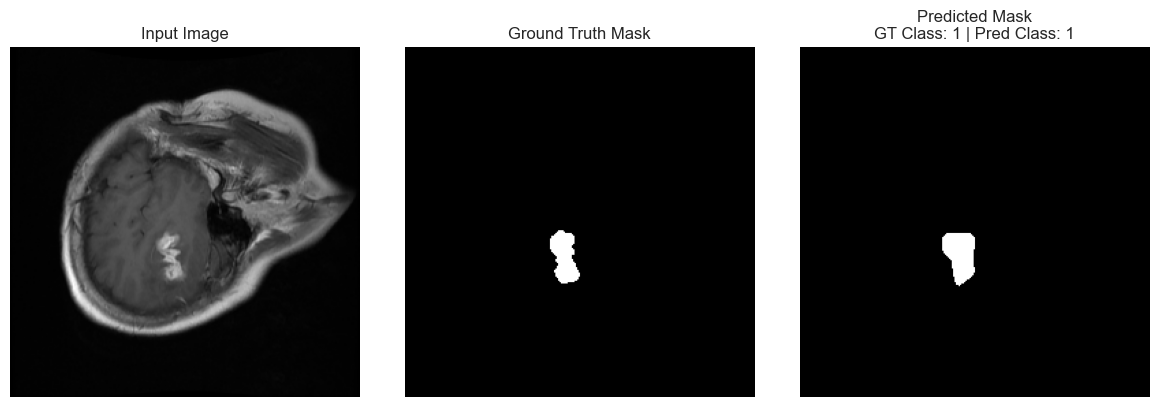

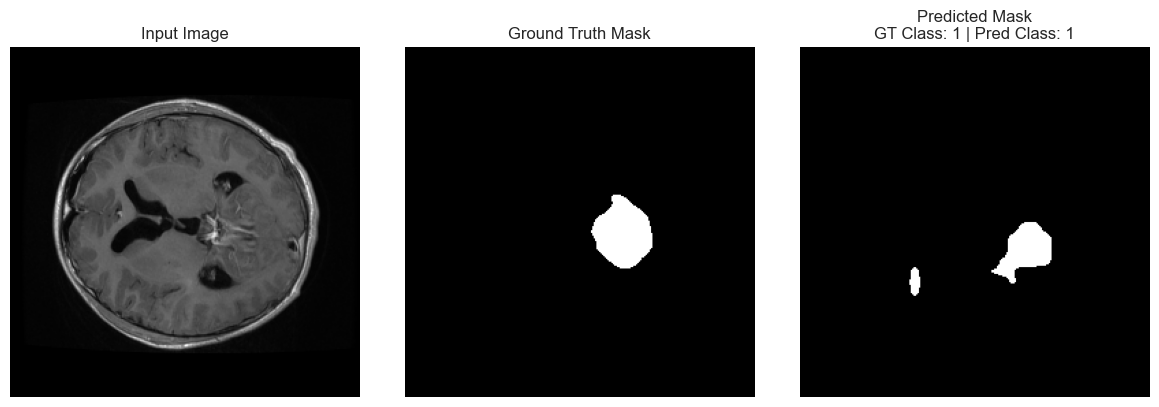

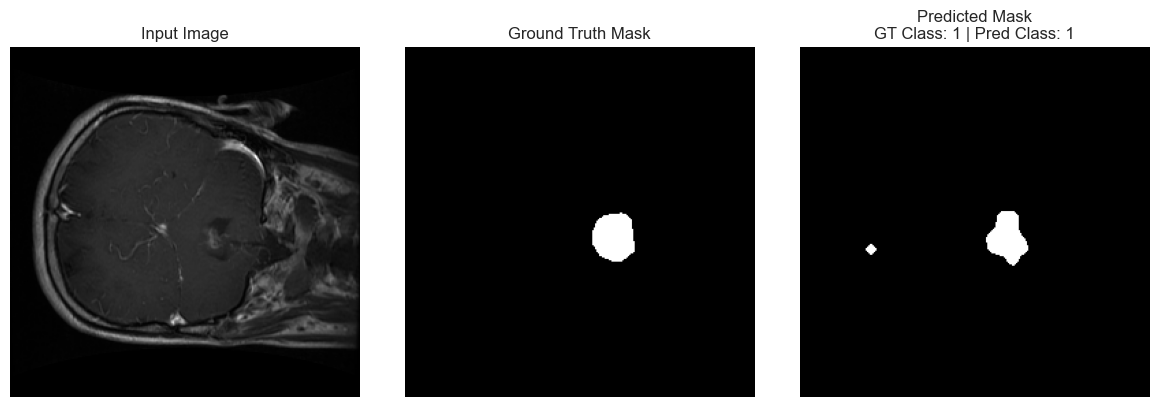

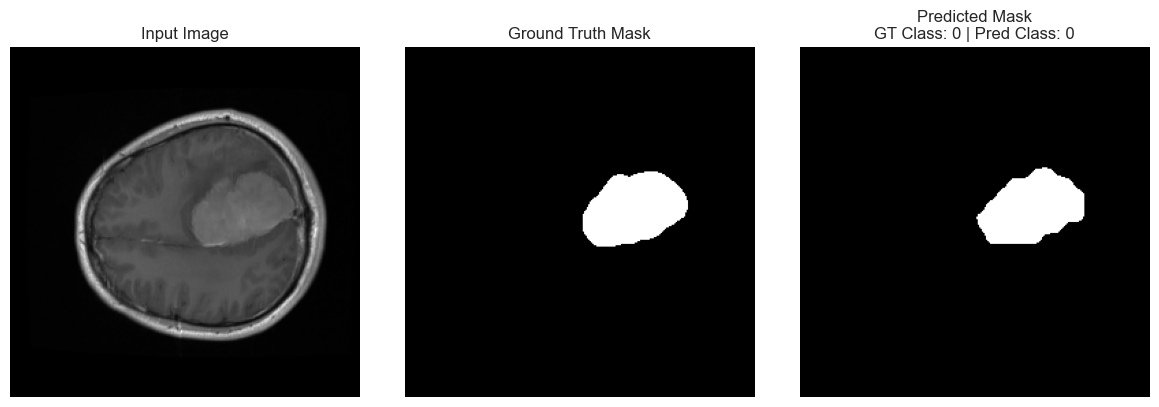

In [16]:
from tqdm import tqdm

freezed_2.eval()

all_images = []
all_masks = []
all_seg_preds = []
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for images, masks, labels in tqdm(test_loader, desc="Collecting test examples"):
        seg_out, class_out = freezed_2(images)

        seg_out = F.interpolate(                      # same upsampling
            seg_out,
            size=masks.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        pred_labels = torch.argmax(class_out, dim=1)

        all_images.append(images)
        all_masks.append(masks)
        all_seg_preds.append(seg_out)
        all_true_labels.append(labels)
        all_pred_labels.append(pred_labels)


all_images = torch.cat(all_images, dim=0)
all_masks = torch.cat(all_masks, dim=0)
all_seg_preds = torch.cat(all_seg_preds, dim=0)
all_true_labels = torch.cat(all_true_labels, dim=0)
all_pred_labels = torch.cat(all_pred_labels, dim=0)


num_samples = 5
indices = torch.randperm(all_images.shape[0])[:num_samples]

for idx in indices:
    image = all_images[idx].cpu().numpy().squeeze()
    mask = all_masks[idx].cpu().numpy().squeeze()
    seg_pred = all_seg_preds[idx].cpu().numpy().squeeze()

    seg_pred_bin = (seg_pred > 0.5).astype(float)

    true_label = all_true_labels[idx].item()
    pred_label = all_pred_labels[idx].item()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground truth mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(seg_pred_bin, cmap='gray')
    plt.title(f"Predicted mask\nGround truth class: {true_label} | Predicted class: {pred_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Save model

In [17]:
trainer.save_checkpoint("classification_segEnc+Dec_frozen_final.ckpt")